In [2]:
%load_ext autoreload
%autoreload 2

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
#import pymaise 



In [3]:
from pyMAISE.datasets import load_anomaly
from pyMAISE.preprocessing import train_test_split, scale_data, one_hot_encode, SplitSequence
import pyMAISE as mai

In [4]:
%%time

global_settings = mai.init(
    problem_type=mai.ProblemType.CLASSIFICATION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only/ Delete line when run on GPU
)

CPU times: user 44 µs, sys: 7 µs, total: 51 µs
Wall time: 52 µs


In [5]:
# call handler
input_path = "./../../../../DTL.npy"
output_path = "./../../../../DTL_labels.npy"
#print(mai.__file__)
#False, False, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)  one hot
#False, True, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)
#False, False, True:  ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#False, True, True:   ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#True, False, True: WORKS        X.shape = (4846500, 14), Y.shape = (4846500, 1)
#True, True, True: WORKS         X.shape = (4846500, 14), Y.shape = (4846500, 1)
cond1 = True
cond2 = False
cond3 = True
inputs, outputs = load_anomaly([input_path, output_path], cond1, cond2, cond3)


In [6]:
inputs

<xarray.DataArray (timesteps: 4846500, features: 14)>
array([[-6.07100e+00,  5.55120e+00, -1.42220e+00, ..., -4.60370e-02,
         2.17170e+03,  1.27100e+00],
       [-4.85030e+00,  4.33040e+00, -2.64290e+00, ...,  1.50000e-02,
         2.17250e+03, -1.33776e+01],
       [-4.85030e+00,  1.88890e+00, -1.42220e+00, ...,  4.55190e-02,
         2.17320e+03, -8.49500e+00],
       ...,
       [-2.17470e+00, -7.57620e+00, -3.39550e+00, ..., -1.07070e-01,
         2.17220e+03,  1.19730e+01],
       [-4.61620e+00, -3.91400e+00, -5.83700e+00, ..., -1.68110e-01,
         2.17180e+03,  9.53200e+00],
       [-3.39550e+00, -6.35550e+00, -5.83700e+00, ..., -4.60370e-02,
         2.17150e+03,  9.53200e+00]], dtype=float32)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U18 'A+IGBT-I: current' ... 'DV/DT'

In [7]:
outputs

<xarray.DataArray (timesteps: 4846500, features: 1)>
array([['Run'],
       ['Run'],
       ['Run'],
       ...,
       ['Fault'],
       ['Fault'],
       ['Fault']], dtype=object)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U5 'Class'

In [8]:
outputs = one_hot_encode(outputs)
outputs

<xarray.DataArray (timesteps: 4846500, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'Class_Fault' 'Class_Run'

In [9]:
data = xr.concat([inputs, outputs], dim="features")
data

<xarray.DataArray (timesteps: 4846500, features: 16)>
array([[ -6.0710001 ,   5.55119991,  -1.42219996, ...,   1.27100003,
          0.        ,   1.        ],
       [ -4.85029984,   4.33039999,  -2.64289999, ..., -13.37759972,
          0.        ,   1.        ],
       [ -4.85029984,   1.88890004,  -1.42219996, ...,  -8.49499989,
          0.        ,   1.        ],
       ...,
       [ -2.17470002,  -7.57620001,  -3.39549994, ...,  11.97299957,
          1.        ,   0.        ],
       [ -4.61619997,  -3.91400003,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ],
       [ -3.39549994,  -6.35550022,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'A+IGBT-I: current' ... 'Class_Run'

In [10]:
split_sequence = SplitSequence(
    10, 
    1, 
    0, 
    sequence_inputs=data.coords["features"].values[:-2], 
    sequence_outputs=data.coords["features"].values[-2:],
)
inputs, outputs = split_sequence.split(data)

inputs

<xarray.DataArray (samples: 4846491, timesteps: 10, features: 14)>
array([[[-6.07100010e+00,  5.55119991e+00, -1.42219996e+00, ...,
         -4.60369997e-02,  2.17169995e+03,  1.27100003e+00],
        [-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        ...,
        [-3.62960005e+00,  1.88890004e+00, -5.08440018e+00, ...,
         -4.60369997e-02,  2.17239990e+03, -1.17100000e+00],
        [-7.29180002e+00,  1.88890004e+00, -3.86360002e+00, ...,
          1.49999997e-02,  2.17230005e+03, -1.33781004e+01],
        [-7.29180002e+00,  3.10969996e+00, -2.64289999e+00, ...,
         -4.60369997e-02,  2.17280005e+03, -1.17100000e+00]],

       [[-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        [-7.29180002e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17300000e+03, -2.31439991e+01],
...
        [-4.61619997e+00, -8.79699993e+00, -4.61619997e+00, ...,
          1.49999997e-02,  2.17180005e+03,  4.64900017e+00],
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00]],

       [[-7.05770016e+00, -7.57620001e+00, -3.39549994e+00, ...,
          1.06559999e-01,  2.17180005e+03,  7.09000015e+00],
        [-4.61619997e+00, -6.35550022e+00, -7.05770016e+00, ...,
         -4.60369997e-02,  2.17160010e+03,  7.09100008e+00],
        [-3.39549994e+00, -8.79699993e+00, -2.17470002e+00, ...,
         -4.60369997e-02,  2.17180005e+03,  1.19740000e+01],
        ...,
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00],
        [-3.39549994e+00, -6.35550022e+00, -5.83699989e+00, ...,
         -4.60369997e-02,  2.17150000e+03,  9.53199959e+00]]])
Coordinates:
  * samples    (samples) int64 0 1 2 3 4 ... 4846487 4846488 4846489 4846490
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler






In [12]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.3)



In [13]:
x_train_scaled, x_test_scaled, x_scaler = scale_data(x_train, x_test, scaler=MinMaxScaler())



In [14]:
y_train_scaled, y_test_scaled, y_scaler = scale_data(y_train, y_test, scaler=MinMaxScaler())

In [15]:
#from tensorflow.keras.layers import GRU
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=y_train_scaled.shape[1], activation='softmax')) # output layer


In [16]:
x_train_scaled.shape[1]

10

In [17]:


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [18]:
%%time


x_train_sampled = x_train_scaled[:20000]  
y_train_sampled = y_train_scaled[:20000]

x_test_sampled = x_test_scaled[:8000]
y_test_sampled = y_test_scaled[:8000]

quick_history = model.fit(
    x_train_sampled,
    y_train_sampled,
    epochs=100,
    batch_size=256,  
    validation_data=(x_test_sampled, y_test_sampled)
)


CPU times: user 2min 48s, sys: 36.4 s, total: 3min 25s
Wall time: 2min 54s


In [19]:
test_loss, test_accuracy = model.evaluate(x_test_sampled, y_test_sampled)



In [20]:
print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.2481
Test Accuracy: 92.59%


In [21]:
x_train.size


474956020

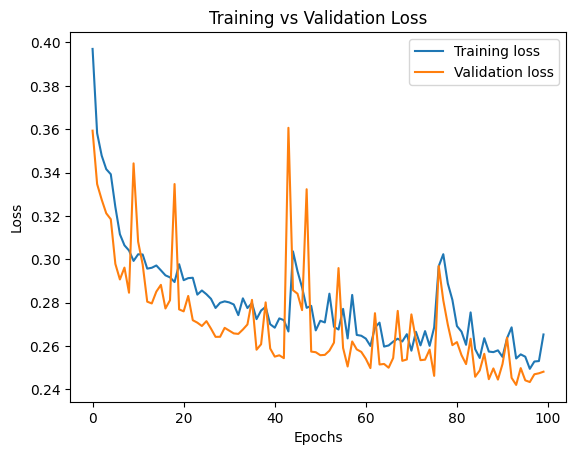

In [22]:
plt.plot(quick_history.history['loss'], label='Training loss')
plt.plot(quick_history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

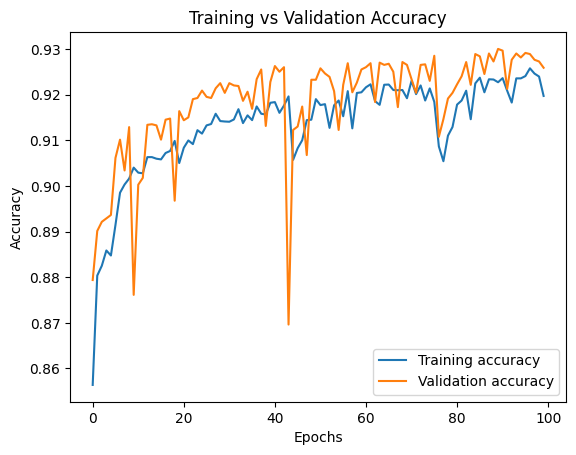

In [23]:
plt.plot(quick_history.history['accuracy'], label='Training accuracy')
plt.plot(quick_history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

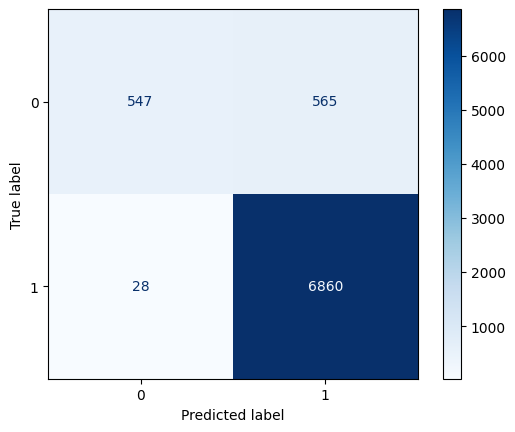

In [24]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_test_sampled_np = y_test_sampled.values 

y_true_classes = np.argmax(y_test_sampled_np, axis=1)

y_pred_prob = model.predict(x_test_sampled.values) 

y_pred_classes = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_true_classes, y_pred_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

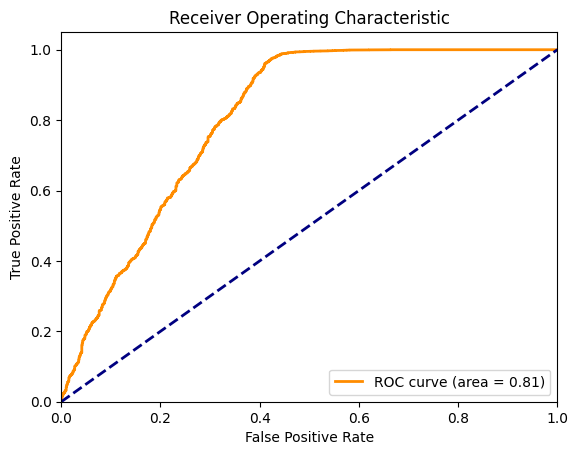

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true_classes, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()